# Deep Cross Correlation between EEG and BOLD signal

#### GOAL: perform convolution among bands and channels for each timestep, with non linear activations, in order to have a signal of the same length as the BOLD signal and correlate them

#### The loss will be the inverse cross correlation between the activation signal and BOLD signal

In [1]:
import sys
sys.path.append("..")

import eeg_utils
import fmri_utils
import deep_cross_corr as deep_corr

import numpy as np
from numpy import correlate

import matplotlib.pyplot as plt

import mne
from nilearn.masking import apply_mask, compute_epi_mask

from sklearn.preprocessing import normalize

from scipy.signal import resample
from nilearn.image import smooth_img, index_img, iter_img, clean_img, math_img, mean_img
from nilearn import plotting
from nilearn import image
from nilearn.input_data import NiftiMasker

/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
mask = fmri_utils.get_population_mask()

/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to

In [3]:
n_partitions = 16

X_train, y_train = deep_corr.get_data(list(range(14)), masker=mask, n_partitions=n_partitions)

X_test, y_test = deep_corr.get_data(list(range(14, 16)), masker=mask, n_partitions=n_partitions)

print(X_train.shape, y_train.shape)

Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(16, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(32, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(48, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(64, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/38/export/20130105380002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 179384  =      0.000 ...   717.536 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(80, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/39/export/20130501390002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 182129  =      0.000 ...   728.516 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(96, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/40/export/20130510400002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 173914  =      0.000 ...   695.656 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(112, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/42/export/20130523420002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 184909  =      0.000 ...   739.636 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(128, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/43/export/20130529430002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 170594  =      0.000 ...   682.376 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(144, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/44/export/20130605440002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 169854  =      0.000 ...   679.416 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


(160, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/45/export/20130627450002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 168099  =      0.000 ...   672.396 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


(176, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/46/export/20130703460002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 172264  =      0.000 ...   689.056 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


(192, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/47/export/20130710470002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 182594  =      0.000 ...   730.376 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


(208, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/48/export/20130717480002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 171739  =      0.000 ...   686.956 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


(224, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/49/export/20130918490002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 167579  =      0.000 ...   670.316 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


(16, 14164, 20)
Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/50/export/20131003_500002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 168019  =      0.000 ...   672.076 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG', 'O9', 'O10']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)
/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


(32, 14164, 20)
(224, 64, 5, 20) (224, 14164, 20)


#### Lack of data, due to only having space for 100 instances:

Our dataset has multiple X instances being equal with different target y

### Defining our network

In [157]:
import keras

from keras.initializers import Zeros
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv3D, Flatten, BatchNormalization, LSTM, TimeDistributed, Dense, Lambda, Input, MaxPooling2D, MaxPooling3D 
from keras.optimizers import Adam
from keras.losses import mae

import keras.backend as K

#hyperparameters to be optimized:
#n_partitions, output_dim, activation_function, reg_l, n_layers, dropout, maxpooling

output_dim = 20
activation_function = 'selu'
reg_l=0
regularizer = regularizers.l1(reg_l)

def eeg_network(input_shape, kernel_size, output_dim=20, activation_function='selu', regularizer=regularizers.l1(0.001)):
    model = Sequential()
    

    model.add(Conv3D(1, kernel_size=(2, 2, kernel_size[2]),
                     activation=activation_function, strides=(2,2,1),
                     input_shape=input_shape, kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer, activity_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv3D(1, kernel_size=(2, 2, kernel_size[2]),
                     activation=activation_function, strides=(2,2,1),
                     input_shape=input_shape, kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer, activity_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv3D(1, kernel_size=(16, 1, kernel_size[2]),
                     activation=activation_function, strides=(2,1,1),
                     input_shape=input_shape, kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer, activity_regularizer=regularizer))
    model.add(BatchNormalization())

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(output_dim))
    
    return model

def bold_network(input_shape, kernel_size, output_dim=20, activation_function='selu', regularizer=regularizers.l1(0.001)):
    model = Sequential()
    
    model.add(Conv2D(1, kernel_size=(100, kernel_size[1]),
                     activation=activation_function, strides=(50,1),
                     input_shape=input_shape, kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer, activity_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(1, kernel_size=(100, kernel_size[1]),
                     activation=activation_function, strides=(12,1),
                     kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer, activity_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(1, kernel_size=(16, kernel_size[1]),
                     activation=activation_function, strides=(1,1),
                     kernel_regularizer=regularizer, 
                    bias_regularizer=regularizer, activity_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(output_dim, input_shape=input_shape))
    
    return model

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1)

eeg_input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)

kernel_size = (X_train.shape[1], X_train.shape[2], 1)
print(kernel_size)
#eeg network
eeg_network = eeg_network(eeg_input_shape, kernel_size, output_dim=output_dim, 
                          activation_function=activation_function, regularizer=regularizer)
print(eeg_network.summary())

#BOLD network (224, 64, 5, 20) (224, 14164, 20)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

bold_input_shape = (y_train.shape[1], y_train.shape[2], 1)

kernel_size = (y_train.shape[1], 1)
print(kernel_size)

bold_network = bold_network(bold_input_shape, kernel_size, output_dim=output_dim, 
                            activation_function=activation_function, regularizer=regularizer)
print(bold_network.summary())

(64, 5, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_198 (Conv3D)          (None, 32, 2, 20, 1)      5         
_________________________________________________________________
batch_normalization_309 (Bat (None, 32, 2, 20, 1)      4         
_________________________________________________________________
conv3d_199 (Conv3D)          (None, 16, 1, 20, 1)      5         
_________________________________________________________________
batch_normalization_310 (Bat (None, 16, 1, 20, 1)      4         
_________________________________________________________________
conv3d_200 (Conv3D)          (None, 1, 1, 20, 1)       17        
_________________________________________________________________
batch_normalization_311 (Bat (None, 1, 1, 20, 1)       4         
_________________________________________________________________
time_distributed_137 (TimeDi (None, 1, 20)             0         

In [158]:
input_eeg = Input(shape=eeg_input_shape)
input_bold = Input(shape=bold_input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_eeg = eeg_network(input_eeg)
processed_bold = bold_network(input_bold)

### Let's define a cross correlation loss

In [159]:
def cross_correlation(x, y):
    #how should the normalization be done??
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)

    a = K.batch_dot(x, y, axes=1)

    b = K.batch_dot(x, x, axes=1)
    c = K.batch_dot(y, y, axes=1)

    return 1 - (a / (K.sqrt(b) * K.sqrt(c)))

def correlation(vects):
    #how should the normalization be done??
    x, y = vects
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)

    a = K.batch_dot(x, y, axes=1)

    b = K.batch_dot(x, x, axes=1)
    c = K.batch_dot(y, y, axes=1)

    return 1 - (a / (K.sqrt(b) * K.sqrt(c)))

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(1.0 - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

correlation = Lambda(correlation,#compare this results with euclidean
              output_shape=cos_dist_output_shape)([processed_eeg, 
              processed_bold])

multi_modal_model = Model([input_eeg, input_bold], correlation)

multi_modal_model.compile(loss=contrastive_loss, optimizer=Adam(lr=0.0001))
eeg_network.compile(loss=cross_correlation, optimizer=Adam(lr=0.0001))

## Create positive and negative pairs of EEG and BOLD

In [153]:
def create_eeg_bold_pairs(eeg, bold):
    x_eeg = []
    x_bold = []
    y = []
    
    #how are we going to pair these? only different individuals??
    #different timesteps of the same individual
    
    #redefine this variable
    instances_per_individual = 10

    #building pairs
    for individual in range(int(len(eeg)/instances_per_individual)):
        for other_individual in range(int(len(eeg)/instances_per_individual)):
            for time_partitions in range(instances_per_individual):
                if(individual == other_individual):
                    x_eeg += [eeg[individual + time_partitions]]
                    x_bold += [bold[other_individual + time_partitions]]
                    y += [[1]]
                else:
                    x_eeg += [eeg[individual + time_partitions]]
                    x_bold += [bold[other_individual + time_partitions]]
                    y += [[0]]
                    print
    
    x_eeg = np.array(x_eeg)
    x_bold = np.array(x_bold)
    y = np.array(y)
    
    return x_eeg, x_bold, y

X_train_eeg, X_train_bold, tr_y = create_eeg_bold_pairs(X_train, y_train)
X_test_eeg, X_test_bold, te_y = create_eeg_bold_pairs(X_test, y_test)

In [160]:
print(X_train_eeg.shape)
print(X_train_bold.shape)

print(X_test_eeg.shape)
print(X_test_bold.shape)

(4840, 64, 5, 20, 1)
(4840, 14164, 20, 1)
(90, 64, 5, 20, 1)
(90, 14164, 20, 1)


## Finally train and see if it converges

In [ ]:
history = multi_modal_model.fit([X_train_eeg, X_train_bold], tr_y, 
                    epochs=100, 
                    batch_size=n_partitions*16, validation_data=([X_test_eeg, X_test_bold], te_y))

Train on 4840 samples, validate on 90 samples
Epoch 1/100


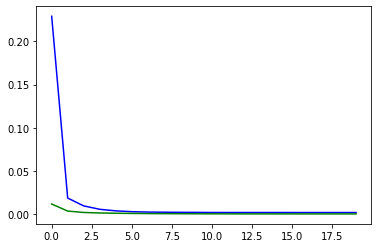

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='g')
plt.show()

## Extract the activations and plot the cross-correlation coefficients

In [ ]:
eeg_embeddings = model.predict(X)

In [ ]:
deep_corr = correlate(eeg_embeddings[0], y[0])
linear_corr = correlate(X[0][0][0].reshape(1,-1)[0], y[0])
print(deep_corr, linear_corr)